# clearmap2_demo_smartspim-manualblocks
In this notebook we'll go through how to run the ClearMap2 cell detection on chunked up "blocks" of an entire SmartSPIM 3.6x volume. 

In the first part of the notebook we will just run the cell detection on two blocks, merge them together and save them as a cells.npy file. 

At the end, we'll go through how to do this for all of the blocks using parallelization on a desktop computer, i.e. not the cluster. Running this on the cluster is the end goal, but it's in development and not covered in this notebook.

# General imports

In [2]:
import os,sys, glob, shutil, pickle
import numpy as np
import matplotlib.pyplot as plt
import tifffile
%matplotlib inline

In [3]:
# this line is so the modules in the next cell get imported. They live in this path.
# Change this to where you cloned ClearMap2 - if running on your PNI desktop, use the local path, not the jukebox path
sys.path.append('/jukebox/wang/ahoag/ClearMap2') 

## Clearmap specific imports

In [4]:
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ParallelProcessing.BlockProcessing as bp
import ClearMap.ImageProcessing.Experts.Cells as cells

## If necessary, link the corrected z planes to a new folder and in the process rename them to Z0000.tif, Z0001.tif, ...
Uncomment the lines below and run (changing paths as necessary) if you still need to do this

In [ ]:
# # symlink files to a new directory with filenames Z0000.tif, Z0001.tif, etc...
# # Change the dst_dir to where you want these z planes linked 
# src_dir = os.path.join('/jukebox/LightSheetData/lightserv/cz15',
#                        'zimmerman_01/zimmerman_01-001/imaging_request_1',
#                        'rawdata/resolution_3.6x/Ex_642_Em_2/corrected')
# dst_dir = '/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/ch647_renamed/corrected' 
# src_files = sorted(glob.glob(src_dir + '/*tif'))
# for ii,src in enumerate(src_files):
#     dst_basename = 'Z' + f'{ii}'.zfill(4) + '.tif'
#     dst = os.path.join(dst_dir,dst_basename)
#     os.symlink(src,dst)
    
    

# Set up the workspace


In [5]:
directory = os.path.join('/jukebox/wang/ahoag/test_clearmap2/output',
             'cz15/zimmerman_01_smartspim/zimmerman_01-001',
             'imaging_request_1/output/ch647_renamed')

expression_raw      = 'corrected/Z<Z,4>.tif'    

ws = wsp.Workspace('CellMap', directory=directory);
ws.update(raw=expression_raw)
ws.debug=False
ws.info()

Workspace[CellMap]{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/ch647_renamed}
              raw: corrected/Z<Z,4>.tif {3589 files, ('Z',): (0,) -> (3588,)}
 autofluorescence: no file
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: cells_block240.npy
                   cells_blocks_240-241.npy
                   cells_maxima.npy
          density: no file



## Verify that the raw data files were corrected read in.
The plot below should show a brain slice and should not be an empty image!

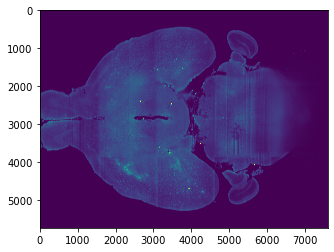

In [6]:
fig=plt.figure()
ax=fig.add_subplot()
z_plane = ws.source('raw')[:,:,2500]
ax.imshow(z_plane,vmin=0,vmax=200)

## If you haven't already, created the "stitched" volume -- this just puts the whole brain into a single stitched.npy file
This takes a while to run! ~ 20 mins for me.
If necessary, uncomment the lines below and then run the cell once. 

In [ ]:
# source = ws.source('raw');
# sink   = ws.filename('stitched')
# io.convert(source, sink, verbose=True) # creates a file called "stitched.npy"

# Make blocks
The first thing to do is figure out how many cores you want to dedicate to this. 

In [7]:
ws.filename('stitched') # this should be the stitched volume of the entire brain

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/ch647_renamed/stitched.npy'

In [8]:
# make the blocks for a 12-core machine and a max size of 10 z planes
# Later, we will want to use larger blocks but this is just a 
# demonstration so I want it to run quickly
# This step is actually very fast even for the whole brain because
# it is just figuring out the boundaries of the blocks. 
# It isn't computing anything significant yet
n_cores = 12
blocks = bp.split_into_blocks(ws.source('stitched'),
                              processes=n_cores,
                              axes=[2], # chunk along z axis
                              size_min=5, size_max=10, overlap=2)

In [9]:
len(blocks)

449

So we have 449 blocks. `blocks` is just a list, and to inspect one of them do:

In [10]:
blocks[0].info()

'0/449<(0, 0, 0)/(1, 1, 449)> (5734, 7592, 9)@(5734, 7592, 3589)[(:,:,0:9)]'

The first part of this tells us this block is the first block in the volume out of 449 blocks: `0/449`. This should really read `1/449`. It's a minor bug in their code but it doesn't actually affect anything besides this printout. The last part of the above line: `[(:,:,0:9)]` tells us which part of the whole volume this block covers. In this case it covers all of x (the first `:`), all of y (the second `:`) and the 9 z planes 0-8. Note that 0:9 actually only includes planes 0-8 due to the Python list slicing convention. This is consistent with what we told it to do above because we said use `size_max=10` and `size_min=5` and a size of 9 which is in between these two numbers. 

The `(5734, 7592, 9)` tells us the size of this block compared to the size of the whole volume `(5734, 7592, 3589)`. The `(0, 0, 0)/(1, 1, 449)` shows which block this is out of how many blocks there are in each dimension. This has the same bug as the `0/449` in that the `(0,0,0)` is 0-indexed, i.e. 0 means first, and the `(1, 1, 449)` is 1-indexed, i.e. 1 means first. So the `(1, 1, 449)` means there is 1 block in the x dimension, 1 block in the y dimension and 449 blocks in the z dimension. Let's look at the second block: 

In [11]:
blocks[1].info()

'1/449<(0, 0, 1)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,7:17)]'

OK as we expect `1/449` means second block out of 120 blocks (again, buggy indexing). Here the size is actually 10 planes but this is still consistent with our `size_max=10`, and the part of the subvolume this block covers is: `[(:,:,7:17)]`. So this covers z planes 7-16, which is 10 z planes in size. Note that this block has an overlap of 2 z planes with block 0 (planes z=7 and z=8), as we told it to when we made the blocks, i.e. `overlap=2`. Finally, let's look at the last block in the list to make sure our entire volume is being covered by these blocks:

In [12]:
blocks[-1].info()

'448/449<(0, 0, 448)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,3579:3589)]'

The `448/449` is the bug I pointed out above. It should read `449/449` but it doesn't really matter. The block is actually the last block, so don't worry about that mismatch. This block fills the last part of the volume: `[(:,:,3579:3589)]`, so we're good. 

# Run the cell detection on a single block as a test 
Almost everything is set up the same as when we ran this in the cellmap tutorial notebook, except the command to do the cell detection on a single block is: `cells.detect_cells_block()` instead of `cells.detect_cells()`. And here we feed the first block in the list as the input to the cell detection function.  Note also that we don't have the processing parameters this time. This is because those parameters were already used when we chunked up the brain. The cell detection on this single block is run on a single core. The parallelization part of this will come later.

Note here we don't want to use the first block because that block is at the very ventral part of the brain and will not contain any cells. For this test let's use one in the middle somewhere. Below I use `blocks[240]` 

In [13]:
%%time
cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['maxima_detection']['valid']=True # keep this on if you want to combine results from multiple blocks

cell_detection_parameter['background_correction']['shape'] = (7,7)
cell_detection_parameter['background_correction']['save'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']
cell_detection_parameter['shape_detection']['threshold'] = 175
cell_detection_parameter['verbose'] = True # set this to False if you don't want to see all of the output

# io.delete_file(ws.filename('cells', postfix='maxima'))
cell_detection_parameter['maxima_detection']['save'] = None


block1_result = cells.detect_cells_block(blocks[240], 
                                         parameter=cell_detection_parameter)

Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Background removal shape: (7, 7)
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Background removal form : Disk
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Background removal save : None
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Illumination correction: elapsed time: 0:00:27.052
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: DoG filter: shape : None
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: DoG filter: sigma : None
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: DoG filter: sigma2: None
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: DoG filter: elapsed time: 0:00:00.0

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:44.381
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Shape detection: elapsed time: 0:01:02.037
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Intensity detection: method: max
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Intensity detection: shape : 3
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Shape detection: elapsed time: 0:01:25.035
Block 240/449<(0, 0, 240)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1917:1927)]: Cell detection: elapsed time: 0:03:29.171
CPU times: user 1min 48s, sys: 1min 2s, total: 2min 51s
Wall time: 3min 30s


The above step took a couple minutes for me, but pretty quickly it should start printing out the same sorts of things that you see when you run the `cells.detect_cells()` function without blocking up the volume first.

In [ ]:
# Let's look at the result:
block1_result

This is a tuple containing 4 arrays. The first array:
```
array([[ 429, 3604, 1918],
        [ 480, 3867, 1918],
        [ 508, 3612, 1918],
        ...,
        [5448, 3919, 1925],
        [5448, 4072, 1925],
        [5461, 3630, 1925]])
```
contains the x,y,z coordinates of the cells detected in this block. As you can see the z coordinates range between 1918 and 1925, which is in the middle of the brain as we picked when we ran the cell detection. Let's take a look at this block to compare what z planes it was supposed to be detecting cells in:

In [ ]:
blocks[240].info()

So here we see that this block covers z planes 1917-1926 (remember the Python slicing convention). But if we compare this to the array of cells coordinates above we see that they only go from 1918 to 1925. This is not a mistake. This is how ClearMap2 deals with the fact that there is an overlap region between blocks. The block before this one will have the cells in the 1917 z plane and the next block after this one (as we will see in a few cells down) will have the cells in planes 1926 and 1927. This means that the detected cell centers from multiple blocks can be combined without worrying about double counting or gaps between blocks. 

The subregion of the block in which cells are actually detected is called the "valid" region of the block. You can see what the size of the valid region is by doing:

In [ ]:
blocks[240].valid.lower

In [ ]:
blocks[240].valid.upper

Note that the shape of the whole block is:

In [ ]:
blocks[240].shape

So the valid region is only planes 1-8 (of this block). The first (i.e. 0th) plane of this block is plane 1917 in the entire volume, but the valid region starts at 1917+1=1918. That is why cells are only detected starting at 1918 above. Likewise for the upper part of the valid region.

## Run on an adjacent block so we have two blocks to merge together later

In [14]:
%%time
block2_result = cells.detect_cells_block(blocks[241], parameter= cell_detection_parameter)

Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Background removal shape: (7, 7)
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Background removal form : Disk
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Background removal save : None
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Illumination correction: elapsed time: 0:00:48.211
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: DoG filter: shape : None
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: DoG filter: sigma : None
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: DoG filter: sigma2: None
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: DoG filter: elapsed time: 0:00:00.0

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:01:13.515
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Shape detection: elapsed time: 0:01:31.283
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Intensity detection: method: max
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Intensity detection: shape : 3
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Shape detection: elapsed time: 0:01:10.261
Block 241/449<(0, 0, 241)/(1, 1, 449)> (5734, 7592, 10)@(5734, 7592, 3589)[(:,:,1925:1935)]: Cell detection: elapsed time: 0:04:07.648
CPU times: user 1min 48s, sys: 55.6 s, total: 2min 44s
Wall time: 4min 8s


In [ ]:
block2_result

As we mentioned above, this block needs to have cells starting at z=1926 to make sure there is no gap and also no overlap with cells in the previous block and that is exactly what we see:
```
array([[ 290, 4168, 1926],
        [ 464, 4107, 1926],
        [ 506, 3666, 1926],
        ...,
        [5458, 4046, 1933],
        [5473, 1275, 1933],
        [5562, 4039, 1933]])
```

## Merge the cell centers from both blocks into a single cells.npy file

In [ ]:
block_result_list = [block1_result,block2_result] # a list containing the two block results we just got
final_results = np.vstack([np.hstack(r) for r in block_result_list]) # merges results into a single array

In [ ]:
final_results.shape

In [ ]:
final_results

In [ ]:
# create the cells numpy array with the same format that ClearMap2 uses when it outputs the cells_raw.npy type file
header = ['x','y','z'];
dtypes = [int, int, int];
if cell_detection_parameter['shape_detection'] is not None:
    header += ['size'];
    dtypes += [int];
measures = cell_detection_parameter['intensity_detection']['measure'];
header +=  measures
dtypes += [float] * len(measures)

dt = {'names' : header, 'formats' : dtypes};
cells_out = np.zeros(len(final_results), dtype=dt);
for i,h in enumerate(header):
    cells_out[h] = final_results[:,i];

In [ ]:
# Let's look at the new array we made
cells_out

This is a little easier to understand than our original results file. Here each row in this array represents a single cell detected. 

The columns are "x,y,z,size,source,background", i.e. the x,y,z coordinates, followed by the size in pixels of the cell, followed by the raw intensity of the entire cell ("source"), followed by the background-corrected intensity of the entire cell ("background"). I think there is a bug in ClearMap2 that causes the source intensity and the background intensity to be identical: https://github.com/ChristophKirst/ClearMap2/issues/60. We don't really use these so it doesn't affect us too much but researchers might be interested in it.

Note that the z range of this file is from 1918 to 1933, so it covers both blocks above showing that the merge of the blocks worked.

In [ ]:
# save the array as an npy file
savename = ws.filename('cells',postfix='blocks_240-241')
io.write(savename,cells_out)

There should now be a file saved at that location on your machine which is in the same format as what you get from running `cells.detect_cells` if you ran it on the subvolume containing only these two central blocks.

# Running this on the entire volume
The idea is basically the same as what we did above, except that instead of 2 blocks, we need to loop over all blocks and then merge them all together. If we did this without parallelization as we did above it would take a very long time to do for the entire volume. Note that the fraction of the volume we ran on above is only 2/449 < 1% of the entire volume and it took ~5 minutes. So to speed things up we will use parallelization. 

## A short example on how to do parallelization with Python
To give you an idea of how parallelization works when you're not using a cluster, let's take a simpler example:
Let's say we have a list of numbers and we want to square them and return the result. We don't actually need parallelization for this example, but it is the simplest example I could think of.

In [ ]:
num_list = np.arange(0,10000)
num_list

In [ ]:
# First, we need a function to do the squaring:
def square(x):
    """ returns the square of x """
    return x**2

In [ ]:
%%time
# without parallelization we would just do:
squares = [] # the list to store the squared values in
for num in num_list:
    squared_num = square(num)
    squares.append(squared_num)

Easy enough, but this isn't practical if the list is billions of items long or more. I use a python library called concurrent to do parallel processing. Here is how I would parallelize this example. 

In [ ]:
%%time
import concurrent
n_cores = 12 # the number of cores to use in parallel. 1 would be no parallel processing
squares_parallel = [] # the list to store the squared values in
with concurrent.futures.ProcessPoolExecutor(max_workers=n_cores) as executor: 
    for result in executor.map(square,num_list): # first argument is the function you run on each input, second is the ENTIRE list 
        try:
            squares_parallel.append(result)
        except Exception as exc:
            print(f'generated an exception: {exc}')

In [ ]:
len(squares_parallel)

In [ ]:
squares_parallel == squares

Note that the parallel method actually took longer in this example. That is going to happen when the input size is small but parallelization wins out when you have a huge input size OR tasks that take a long time on a single core, like our cell detection on a single block. Also note that the order in which the `squares_parallel` list gets added to from the various cores is not necessarily going to happen in the right order. For our block cell detection this doesn't actually matter because we can save the results from the blocks independently and then merge them later. 

## Running cell detection on the entire brain using parallelization

In [ ]:
# As before we need to make the blocks. In this case let's make larger blocks so there are fewer of them.
# Feel free to tweak these as needed
n_cores = 12 # Pretty sure this is the max for John's desktop but you can check it with os.cpu_count() 
blocks = bp.split_into_blocks(ws.source('stitched'),
                              processes=n_cores,
                              axes=[2], # chunk along z axis
                              size_min=30, size_max=50, overlap=15)

In [ ]:
len(blocks)

In [ ]:
# Settle on our cell detection parameters that we are going to use for all blocks
cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['maxima_detection']['valid']=True # keep this on if you want to combine results from multiple blocks

cell_detection_parameter['background_correction']['shape'] = (7,7)
cell_detection_parameter['background_correction']['save'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']
cell_detection_parameter['shape_detection']['threshold'] = 175
cell_detection_parameter['verbose'] = False # I set this to False because I didn't want to see the output like "running background removal" stuff for each of the ~100 or so blocks

cell_detection_parameter['maxima_detection']['save'] = None

In [ ]:
# The first thing you do when you want to parallelize something is write down the function
# that acts on a single input, in our case a single block. This is analagous to our square() function 
# in the simple example above
def process_block(block,cell_detection_parameters=cell_detection_parameters,):
    """
    ---PURPOSE---
    A function that takes a block as input and 
    runs the cells.detect_cells_block() function on it.
    
    We then save the results in an array so that we 
    can just load them later when we want to merge this all together
    ---INPUT---
    block                       A processing block created from bp.split_into_blocks()
    cell_detection_parameters   The cell detection parameter dictionary 
                                that you feed into detect_cells_block()
    ---OUTPUT---
    block_result      The tuple containing the cell coordinates, shape, intensities 
    It also saves this block_result as a file in your output directory called:
                      "cells_block{block_index}.p" where block_index is ranges from 0 to the number of blocks-1
    """
    block_index = block.index[-1]
    block_result = cells.detect_cells_block(block, parameter= cell_detection_parameter)
    block_savename = os.path.join(directory,f'cells_block{block_index}.p')
    with open(block_savename,'wb') as pkl:
        pickle.dump(block_result,pkl)
    print(f"Saved {block_savename}")
    return block_result

In [ ]:
%%time
# OK, we have our list of blocks to process and our function, now we just need to take the 
# parallel processing example above and adapt it to these two things:
# Note that this cell will take a very long time to run and will halt your jupyter notebook 

import concurrent
n_cores = 12 # the number of cores to use in parallel. 1 would be no parallel processing
with concurrent.futures.ProcessPoolExecutor(max_workers=n_cores) as executor: 
    for block_result in executor.map(process_block,blocks): # first argument is the function you run on each input, second is the ENTIRE list 
        try:
            print(block_result)
            print("success")
        except Exception as exc:
            print(f'generated an exception: {exc}')

Note that I didn't actually run this previous cell because I was on scotty and it's not practical to do this on that machine. So I don't know how long it takes. 

However, assuming it doesn't crash your notebook and completes, you are now ready to merge together all of the results. First we need to load them all from file, then we need to merge them and convert them to the file format that ClearMap2 uses. This we can do in series and don't need parallel processing. 

In [22]:
%%time 
for block in blocks:
    block_index = block.index[-1]
    print(f"Working on block {block_index}")
    block_savename = os.path.join(directory,f'cells_block{block_index}.p')
    block_result_list = []
    with open(block_savename,'rb') as pkl:
        block_result = pickle.load(pkl)
        block_result_list.append(block_result)
    final_results = np.vstack([np.hstack(r) for r in block_result_list]) # merges results into a single array
    # create the cells numpy array with the same format that ClearMap2 uses when it outputs the cells_raw.npy type file
    header = ['x','y','z']
    dtypes = [int, int, int]
    if cell_detection_parameter['shape_detection'] is not None:
        header += ['size'];
        dtypes += [int];
    measures = cell_detection_parameter['intensity_detection']['measure']
    header +=  measures
    dtypes += [float] * len(measures)

    dt = {'names' : header, 'formats' : dtypes}
    cells_allblocks = np.zeros(len(final_results), dtype=dt);
    for i,h in enumerate(header):
        cells_allblocks[h] = final_results[:,i]
    # save the array as an npy file
    savename = ws.filename('cells',postfix='allblocks')
    io.write(savename,cells_allblocks)
    print(f"wrote {savename}")

Working on block 240
wrote /jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/ch647_renamed/cells_allblocks.npy
Working on block 241
wrote /jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/ch647_renamed/cells_allblocks.npy
CPU times: user 9.13 ms, sys: 6.77 ms, total: 15.9 ms
Wall time: 34.5 ms
